In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm  # For progress bar

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import os


In [38]:
# Load the CSV file
df = pd.read_csv("data/Fake.csv")

# Get the number of rows in the CSV file
n_rows = len(df)

# Sample 20% of the rows randomly
sample_size = int(n_rows * 0.2)
random_indices = np.random.choice(n_rows, sample_size, replace=False)

# Create a new CSV file with the sampled rows
df_sample = df.iloc[random_indices]
df_sample.to_csv("data/fake_test_20.csv", index=False)

# Save the rest of the rows into a new CSV file
df_rest = df.loc[~df.index.isin(random_indices)]
df_rest.to_csv("data/fake_train_80.csv", index=False)

In [39]:
# Load the CSV file
df = pd.read_csv("data/Real.csv")

# Get the number of rows in the CSV file
n_rows = len(df)

# Sample 20% of the rows randomly
sample_size = int(n_rows * 0.2)
random_indices = np.random.choice(n_rows, sample_size, replace=False)

# Create a new CSV file with the sampled rows
df_sample = df.iloc[random_indices]
df_sample.to_csv("data/real_test_20.csv", index=False)

# Save the rest of the rows into a new CSV file
df_rest = df.loc[~df.index.isin(random_indices)]
df_rest.to_csv("data/real_train_80.csv", index=False)

In [40]:
# Load the data
df_real = pd.read_csv("data/real_train_80.csv") 
df_fake = pd.read_csv("data/fake_train_80.csv")

# Add labels to the datasets
df_fake['isReal'] = 0  # add label
df_real['isReal'] = 1  # add label

# Concatenate real and fake news
df = pd.concat([df_real, df_fake]).reset_index(drop = True)
df.head()

,title,text,subject,date,isReal
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1
4,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1


In [41]:
# Check if the dataset is class-unbalanced or not
print( df['isReal'].value_counts() )
print()
if 0.9 < (df['isReal'].value_counts()[0] / df['isReal'].value_counts()[1]) < 1.1:
  print('Dataset is class-balanced')
else:
  print('Dataset is class-unbalenced')

isReal
0    18785
1    17134
Name: count, dtype: int64

Dataset is class-balanced


In [42]:
# Combine title and text together
df['combine'] = df['title'] + ' ' + df['text']
# Shuffle the dataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Download stopwords
nltk.download("stopwords")

# Endlish stopwords
stop_words = stopwords.words('english')
stop_words[:10]

# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

# Apply the function to the dataframe
df['clean'] = df['combine'].apply(preprocess)

# Join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


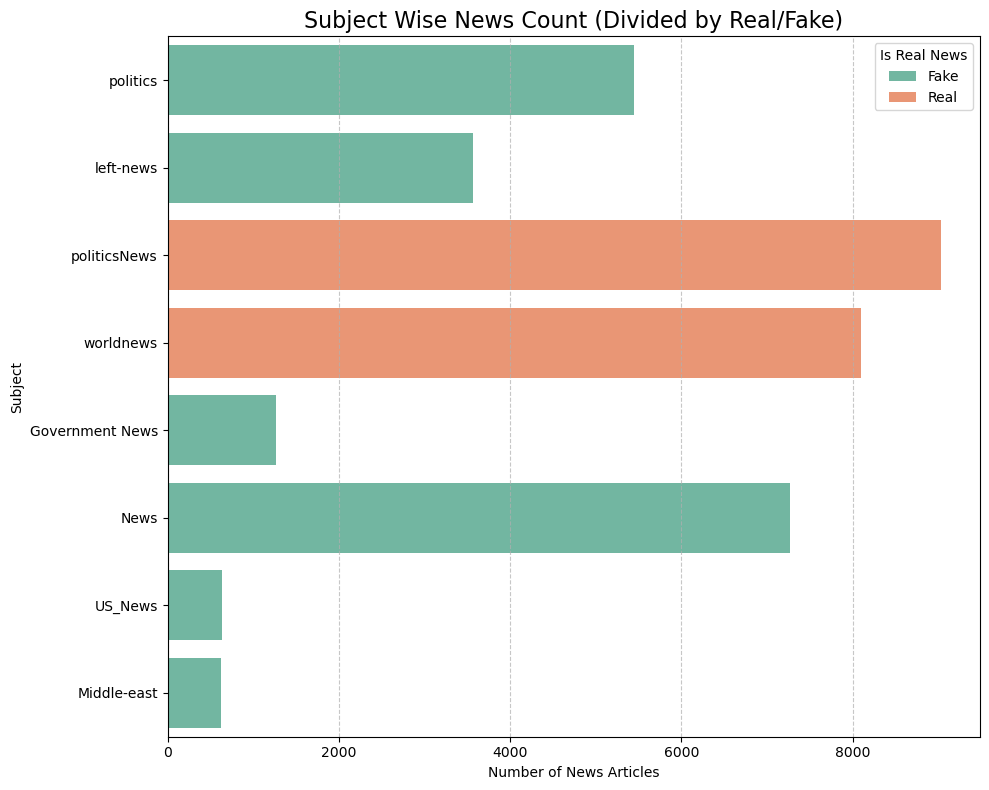

In [14]:
# Plot the number of samples in each subject
plt.figure(figsize=(10, 8))
plt.title("Subject Wise News Count (Divided by Real/Fake)", fontsize=16)

# hue="isReal" splits the bars between real (1) and fake (0)
sns.countplot(y="subject", data=df, hue="isReal", palette="Set2")

plt.xlabel("Number of News Articles")
plt.ylabel("Subject")
plt.legend(title="Is Real News", labels=["Fake", "Real"])
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [43]:
# Drop the 'subject' column as it has a strong correlation with the label
df = df.drop(columns=['subject'])

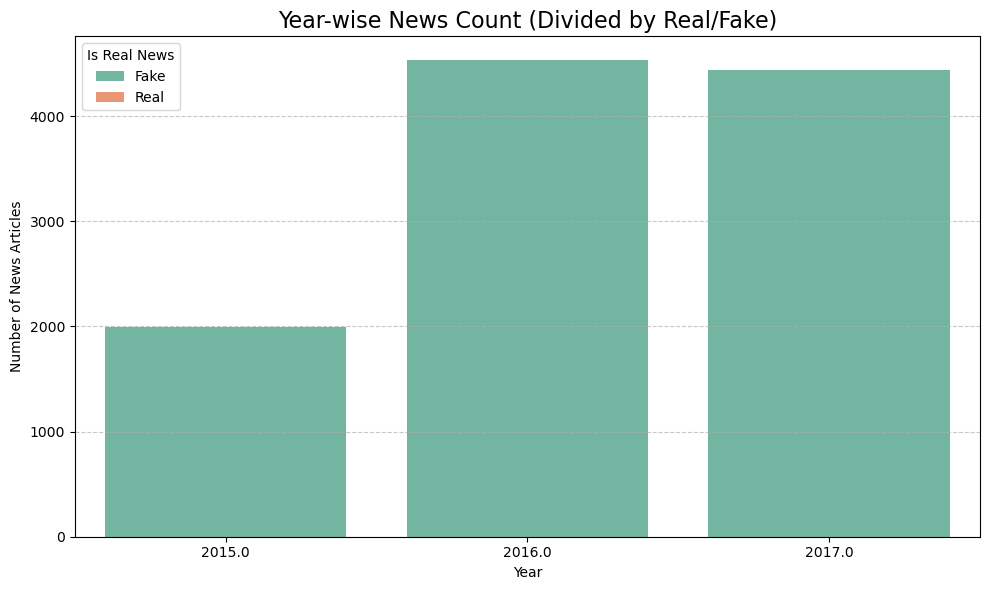

In [44]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract the year from the date
df['year'] = df['date'].dt.year

plt.figure(figsize=(10, 6))
plt.title("Year-wise News Count (Divided by Real/Fake)", fontsize=16)

# hue="isReal" splits bars into real/fake
sns.countplot(x="year", data=df, hue="isReal", palette="Set2")

plt.xlabel("Year")
plt.ylabel("Number of News Articles")
plt.legend(title="Is Real News", labels=["Fake", "Real"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [45]:
# # Drop the 'date' and 'year'columns as 'year' has a strong correlation with the label
df = df.drop(columns=['date', 'year'])

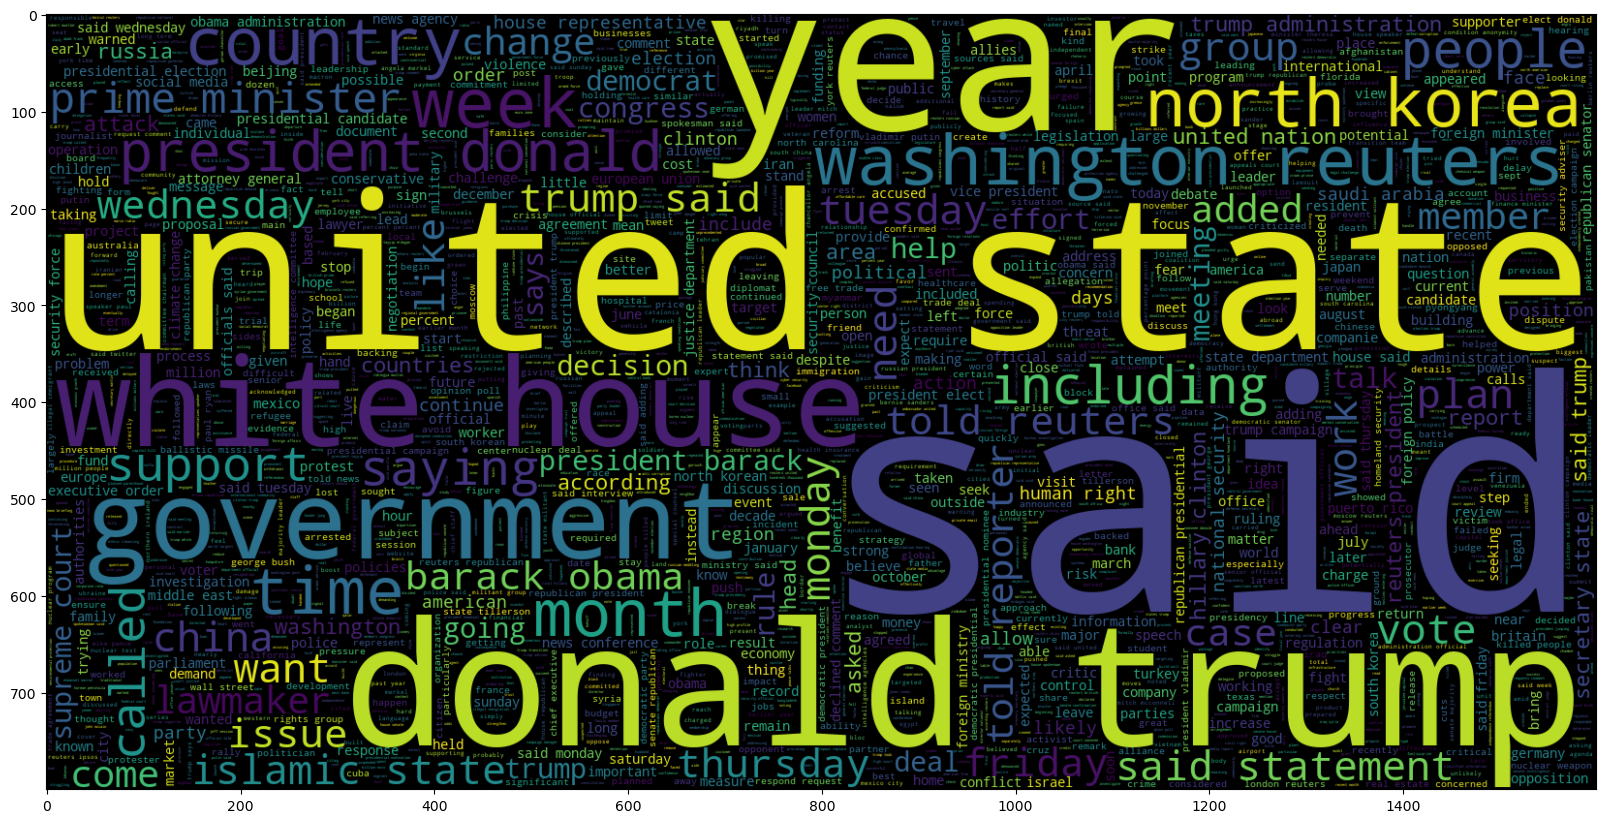

In [11]:
# Plot the word cloud for text that is real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isReal == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

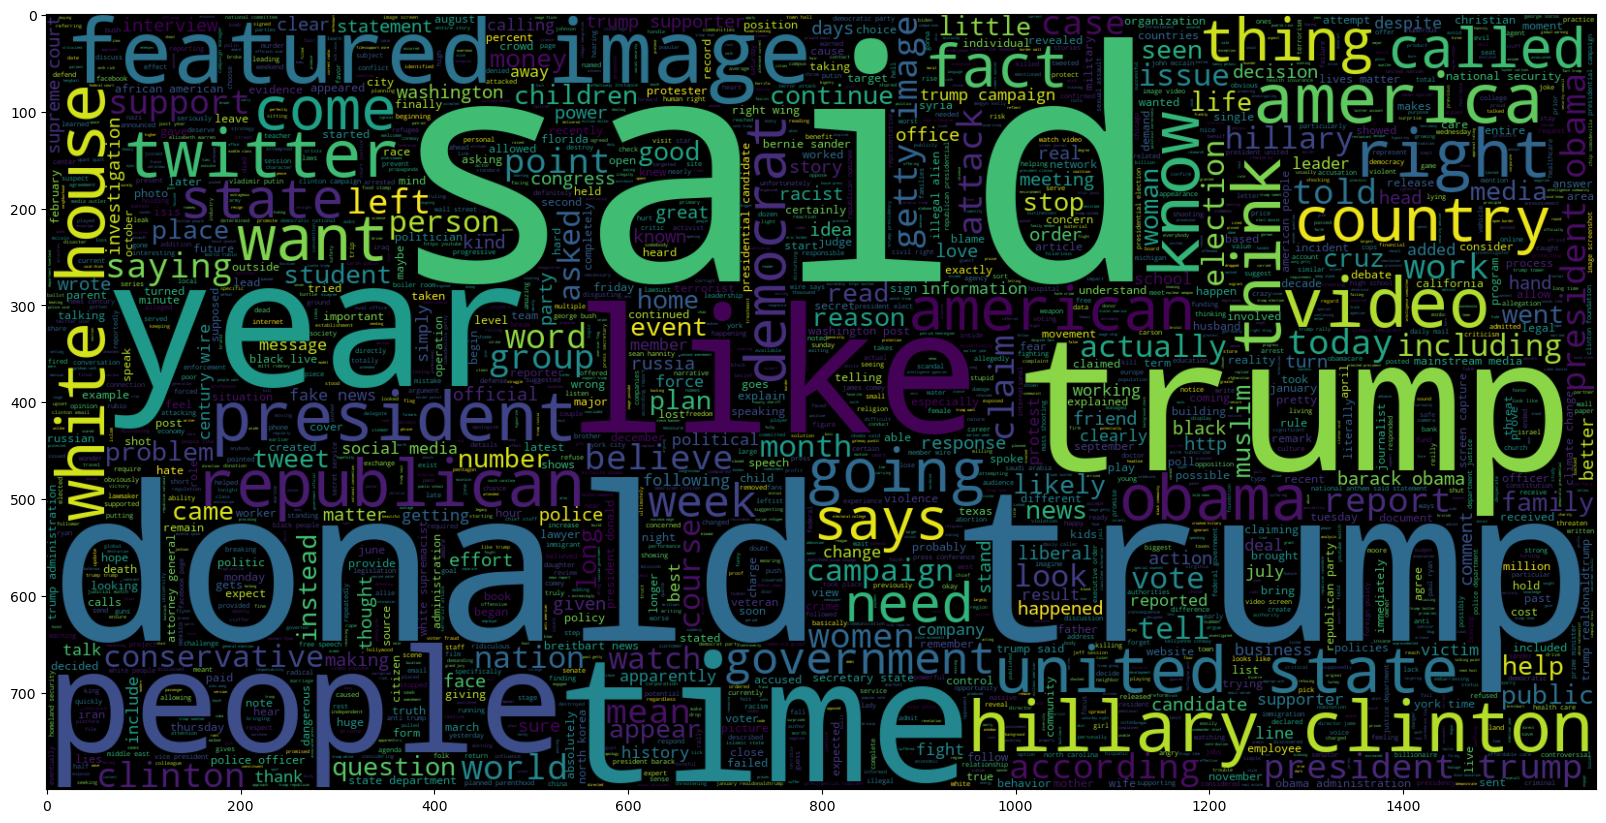

In [12]:
# Plot the word cloud for text that is fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isReal == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')
# Determine the maximum number of tokens in any document, required to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of tokens in any document is =", maxlen)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


The maximum number of tokens in any document is = 4405


In [14]:
# Visualize the distribution of number of tokens in a text
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [15]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

99341

In [47]:
# Implement BERT classifier in PyTorch with frozen encoder

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Classifier layers
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # shape: (batch_size, seq_length, hidden_size)

        # Global average pooling over the sequence length
        x = last_hidden_state.permute(0, 2, 1)  # (batch_size, hidden_size, seq_length)
        x = self.pool(x).squeeze(-1)             # (batch_size, hidden_size)

        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [13]:
# Replace the tokenizer instantiation with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
# Convert the dataset to features as the input for Bert model
def convert_examples_to_features(texts, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',           
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True,
            return_tensors='pt'              # Output as PyTorch tensors directly
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Concatenate into big tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Apply on the training data
x_train = df['clean_joined']
y_train = torch.tensor(df['isReal'].values)  # Labels as PyTorch tensor

input_ids, attention_mask = convert_examples_to_features(x_train, tokenizer, max_length=512)


In [19]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertClassifier()
model.to(device)  
print(model)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [15]:
# Create a custom dataset class
class NewsDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }
    
# Create Dataset
train_dataset = NewsDataset(input_ids, attention_mask, y_train)

# Split into train/validation sets 
train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset)),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_data = Subset(train_dataset, train_indices)
val_data = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

In [21]:
# Define optimizer and loss
optimizer = optim.RMSprop(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification

# Training Loop
best_val_loss = float('inf')

for epoch in range(30):  # 30 epochs
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)  # Important: BCELoss expects float labels

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        outputs = outputs.view(-1)  # Flatten outputs to (batch_size,) for BCELoss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            outputs = model(input_ids, attention_mask)
            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            preds = (outputs > 0.5).float()  # Threshold for binary classification
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.4f}")


    # Save best model manually
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "bert_pretrain_classifier.pt")
        print(f"Saved new best model at epoch {epoch+1}!")

Epoch 1: Train Loss = 0.5544, Val Loss = 0.4164, Val Acc = 0.8920
Saved new best model at epoch 1!
Epoch 2: Train Loss = 0.3537, Val Loss = 0.3006, Val Acc = 0.8946
Saved new best model at epoch 2!
Epoch 3: Train Loss = 0.2819, Val Loss = 0.2650, Val Acc = 0.8988
Saved new best model at epoch 3!
Epoch 4: Train Loss = 0.2551, Val Loss = 0.2473, Val Acc = 0.9033
Saved new best model at epoch 4!
Epoch 5: Train Loss = 0.2425, Val Loss = 0.2371, Val Acc = 0.9049
Saved new best model at epoch 5!
Epoch 6: Train Loss = 0.2310, Val Loss = 0.2310, Val Acc = 0.9063
Saved new best model at epoch 6!
Epoch 7: Train Loss = 0.2260, Val Loss = 0.2196, Val Acc = 0.9119
Saved new best model at epoch 7!
Epoch 8: Train Loss = 0.2189, Val Loss = 0.2141, Val Acc = 0.9140
Saved new best model at epoch 8!
Epoch 9: Train Loss = 0.2119, Val Loss = 0.2108, Val Acc = 0.9155
Saved new best model at epoch 9!
Epoch 10: Train Loss = 0.2096, Val Loss = 0.2059, Val Acc = 0.9177
Saved new best model at epoch 10!
Epoch 11

In [18]:
# Step 1: Recreate the model
model = BertClassifier()
model.load_state_dict(torch.load("bert_pretrain_classifier.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("✅ Model loaded from checkpoint.")

# Step 2: Lower the learning rate
new_lr = 5e-6  # previously 1e-5
optimizer = optim.RMSprop(model.parameters(), lr=new_lr)
criterion = nn.BCELoss()

# Step 3: Resume training
best_val_loss = float('inf')  # optional: reset or continue tracking
start_epoch = 31  # continue from the last epoch
num_epochs = 30

for epoch in range(start_epoch, start_epoch + num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            outputs = model(input_ids, attention_mask).view(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "bert_pretrain_classifier.pt")
        print(f"✅ Saved new best model at epoch {epoch+1}!")


✅ Model loaded from checkpoint.
Epoch 31: Train Loss = 0.1891, Val Loss = 0.1665, Val Acc = 0.9336
✅ Saved new best model at epoch 32!
Epoch 32: Train Loss = 0.1889, Val Loss = 0.1630, Val Acc = 0.9350
✅ Saved new best model at epoch 33!
Epoch 33: Train Loss = 0.1894, Val Loss = 0.1606, Val Acc = 0.9374
✅ Saved new best model at epoch 34!
Epoch 34: Train Loss = 0.1893, Val Loss = 0.1626, Val Acc = 0.9353
Epoch 35: Train Loss = 0.1874, Val Loss = 0.1649, Val Acc = 0.9344
Epoch 36: Train Loss = 0.1863, Val Loss = 0.1651, Val Acc = 0.9346
Epoch 37: Train Loss = 0.1872, Val Loss = 0.1597, Val Acc = 0.9379
✅ Saved new best model at epoch 38!
Epoch 38: Train Loss = 0.1870, Val Loss = 0.1654, Val Acc = 0.9346
Epoch 39: Train Loss = 0.1873, Val Loss = 0.1643, Val Acc = 0.9347
Epoch 40: Train Loss = 0.1869, Val Loss = 0.1617, Val Acc = 0.9362
Epoch 41: Train Loss = 0.1846, Val Loss = 0.1597, Val Acc = 0.9375
Epoch 42: Train Loss = 0.1881, Val Loss = 0.1672, Val Acc = 0.9336
Epoch 43: Train Loss

In [48]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/mdebertav3-subjectivity-english")
model = AutoModelForSequenceClassification.from_pretrained("GroNLP/mdebertav3-subjectivity-english")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Add columns for subjectivity scores
df['subj_score'] = 0.0
df['obj_score'] = 0.0

# Compute scores for all sentences
for i in tqdm(range(len(df))):
    text = df.loc[i, 'clean_joined']
    
    # Tokenize and move to device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[0]

        df.at[i, 'obj_score'] = probs[0].item()
        df.at[i, 'subj_score'] = probs[1].item()


100%|██████████| 35919/35919 [07:39<00:00, 78.25it/s]


In [52]:
df.to_csv("data/train_obj_score.csv", index=False)

14171 out of 18785 fake news articles are subjective.
That's 75.44% subjective.

647 out of 17134 real news articles are subjective.
That's 3.78% subjective.



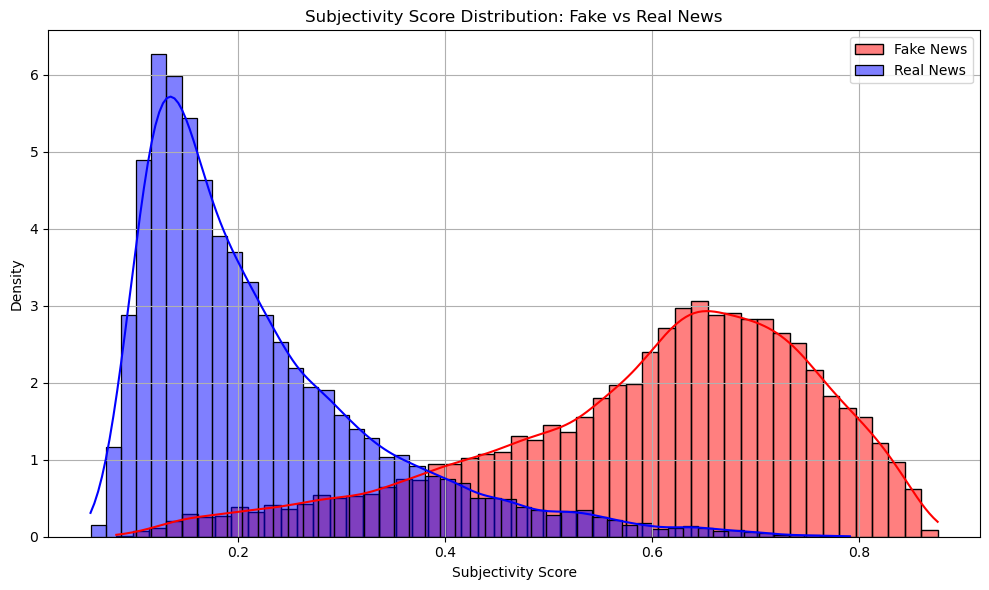

In [50]:
# Filter only fake news
fake_df = df[df['isReal'] == 0]

# Count how many are subjective
subjective_count_f = (fake_df['subj_score'] > 0.5).sum()
total_fake = len(fake_df)

print(f"{subjective_count_f} out of {total_fake} fake news articles are subjective.")
print(f"That's {(subjective_count_f / total_fake) * 100:.2f}% subjective.")

# Filter only real news
real_df = df[df['isReal'] == 1]

# Count how many are subjective
subjective_count_r = (real_df['subj_score'] > 0.5).sum()
total_real = len(real_df)

print(f"\n{subjective_count_r} out of {total_real} real news articles are subjective.")
print(f"That's {(subjective_count_r / total_real) * 100:.2f}% subjective.\n")

plt.figure(figsize=(10, 6))
sns.histplot(fake_df['subj_score'], color='red', label='Fake News', bins=50, kde=True, stat='density')
sns.histplot(real_df['subj_score'], color='blue', label='Real News', bins=50, kde=True, stat='density')
plt.title("Subjectivity Score Distribution: Fake vs Real News")
plt.xlabel("Subjectivity Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Count tokens and whether they will be truncated
df['token_count'] = df['clean_joined'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
df['was_truncated'] = df['token_count'] > 512

print(f"Number of truncated samples: {df['was_truncated'].sum()} / {len(df)}")


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


Number of truncated samples: 2061 / 35919


In [53]:
# Save the DataFrame with subjectivity and objectivity scores and token counts
df.to_csv("data/train_obj_score_token_counts.csv", index=False)
df.head(10)

,title,text,isReal,combine,clean,clean_joined,subj_score,obj_score,token_count,was_truncated
0,(VIDEO) WOW! THIS RACIST STATEMENT FROM JEB BU...,Stereotype much? Wow! This entire statement is...,0,(VIDEO) WOW! THIS RACIST STATEMENT FROM JEB BU...,"[video, racist, statement, bush, worst, said, ...",video racist statement bush worst said immigra...,0.844142,0.155858,31,False
1,"ILLEGAL ALIENS WHO LIED TO COURT, USED FAKE SS...",You can t make this up! Why are these criminal...,0,"ILLEGAL ALIENS WHO LIED TO COURT, USED FAKE SS...","[illegal, aliens, lied, court, fake, committed...",illegal aliens lied court fake committed felon...,0.197596,0.802404,578,True
2,#FakeNewsMorningShow GMA Compares President Tr...,Beyond the pale ABC reporter Matthew Dowd comp...,0,#FakeNewsMorningShow GMA Compares President Tr...,"[compares, president, trump, korean, murderous...",compares president trump korean murderous dict...,0.532548,0.467452,201,False
3,Sanders expected to endorse Clinton on Tuesday...,WASHINGTON (Reuters) - Democrat Bernie Sanders...,1,Sanders expected to endorse Clinton on Tuesday...,"[sanders, expected, endorse, clinton, tuesday,...",sanders expected endorse clinton tuesday york ...,0.110876,0.889124,154,False
4,Trump's Pentagon choice says U.S. needs to be ...,WASHINGTON (Reuters) - Donald Trump’s pick to ...,1,Trump's Pentagon choice says U.S. needs to be ...,"[trump, pentagon, choice, says, needs, ready, ...",trump pentagon choice says needs ready confron...,0.162392,0.837608,501,False
5,German legal experts say Poland has no right t...,BERLIN (Reuters) - German parliamentary legal ...,1,German legal experts say Poland has no right t...,"[german, legal, experts, poland, right, repara...",german legal experts poland right reparations ...,0.148556,0.851444,200,False
6,PRICELESS! RACE BAITER JOHN LEWIS Bombarded Wi...,The protesters are breaking all the rules and ...,0,PRICELESS! RACE BAITER JOHN LEWIS Bombarded Wi...,"[priceless, race, baiter, john, lewis, bombard...",priceless race baiter john lewis bombarded hec...,0.852776,0.147224,31,False
7,Cambodia marks independence from France with d...,PHNOM PENH (Reuters) - Cambodians on Thursday ...,1,Cambodia marks independence from France with d...,"[cambodia, marks, independence, france, doves,...",cambodia marks independence france doves ballo...,0.264847,0.735153,139,False
8,Egypt security forces kill nine suspected mili...,CAIRO (Reuters) - Egyptian security forces on ...,1,Egypt security forces kill nine suspected mili...,"[egypt, security, forces, kill, suspected, mil...",egypt security forces kill suspected militants...,0.125120,0.874880,145,False
9,ELECTION WHISTLEBLOWER: DOJ In Cahoots With De...,J. Christian Adams: Dead people are voting and...,0,ELECTION WHISTLEBLOWER: DOJ In Cahoots With De...,"[election, whistleblower, cahoots, dems, milli...",election whistleblower cahoots dems million de...,0.493386,0.506615,76,False


In [54]:
# Load your model
model = BertClassifier()
model.load_state_dict(torch.load("bert_pretrain_classifier.pt"))
model.to(device)
model.eval()

# Prepare column
df['real_prob'] = 0.0

# Loop through rows and compute probability
for i in tqdm(range(len(df))):
    text = df.loc[i, 'clean_joined']

    # Tokenize with truncation for BERT input
    encoded = tokenizer(
        text,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        prob_real = output.squeeze().item()  # sigmoid output ∈ [0, 1]

    df.at[i, 'real_prob'] = prob_real

100%|██████████| 35919/35919 [05:05<00:00, 117.72it/s]


In [ ]:
# Save the augmented DataFrame with subjectivity and objectivity scores, token counts, and real probability
df = df.drop(columns=['title', 'text', 'combine', 'clean', 'obj_score'])
df.to_csv("data/train_obj_score_token_counts_real_prob.csv", index=False)
df.head(10)

,isReal,clean_joined,subj_score,token_count,was_truncated,real_prob
0,0,video racist statement bush worst said immigra...,0.844142,31,False,0.000052
1,0,illegal aliens lied court fake committed felon...,0.197596,578,True,0.335299
2,0,compares president trump korean murderous dict...,0.532548,201,False,0.297464
3,1,sanders expected endorse clinton tuesday york ...,0.110876,154,False,0.994408
4,1,trump pentagon choice says needs ready confron...,0.162392,501,False,0.972349
5,1,german legal experts poland right reparations ...,0.148556,200,False,0.998895
6,0,priceless race baiter john lewis bombarded hec...,0.852776,31,False,0.000052
7,1,cambodia marks independence france doves ballo...,0.264847,139,False,0.999101
8,1,egypt security forces kill suspected militants...,0.125120,145,False,0.995688
9,0,election whistleblower cahoots dems million de...,0.493386,76,False,0.040294
